## Set up Dataset

In [1]:
import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

config = cf.read_json("../experiments/exp_r4_linear_output/quad_default/config.json")
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])
torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

# Force Test Set
val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

### Load Model

In [2]:
import torch
import torch.nn as nn
import sys

model = torch.load("../experiments/exp_r4_linear_output/quad_default/checkpoint_quad_default_92_val_mrr=0.09293122.pth")

/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.FeedForwardQuadrupletNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anaconda/anaconda3/envs/siamese/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'models.SNN_Embedder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/repo/chemprop/pcba/model_unoptimized.pt")

In [4]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return gex_raw, gex_embeddings, chem_embeddings_all, chem_embeddings, chem_embeddings_all_chemprop, chem_embeddings_chemprop, np.array(smiles_gex_labels), np.array(smiles_chem_labels)

In [5]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_unique, chem_embeddings_chemprop, chem_embeddings_unique_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, chem_embeddings_chemprop.shape, chem_embeddings_unique_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((5069, 2934),
 (5069, 128),
 (5069, 128),
 (3370, 128),
 (5069, 300),
 (3370, 300),
 5069,
 3370)

In [6]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_unique_train, chem_embeddings_chemprop_train, chem_embeddings_unique_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_unique_train.shape , chem_embeddings_chemprop_train.shape, chem_embeddings_unique_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((29548, 2934),
 (29548, 128),
 (29548, 128),
 (6318, 128),
 (29548, 300),
 (6318, 300),
 29548,
 6318)

In [7]:
import pandas as pd
gex_embeddings_mean_pd = pd.DataFrame(data=gex_embeddings, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_pd = pd.DataFrame(data=chem_embeddings_unique, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()
assert(all(gex_embeddings_mean_pd.index.values == chem_embeddings_mean_pd.index.values))

# Distance Computations

## Model space

In [8]:
from scipy.spatial.distance import cdist

## Tanimoto similarity

In [ ]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem


In [ ]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms = [MolFromSmiles(x) for x in smiles_chem_labels]
fingerprints_unique = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms_train])

fingerprints.shape, fingerprints_unique.shape, fingerprints_train.shape

((5069, 128), (3370, 128), (29548, 128))

## GE similarity 

## Correlations of Distances

## Ranking results

In [ ]:
from scipy.stats.mstats import rankdata
import seaborn as sns

def get_ind_first_match(smiles_gex_labels, smiles_chem_labels):
    inds_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        match = np.where(smiles_chem_labels == sml)[0]
    rank_first_match = np.array(rank_first_match).squeeze()
    inds_first_match = np.array(inds_first_match).squeeze()
    return inds_first_match

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def get_val_scores(distmat,
                   smiles_gex_labels=smiles_gex_labels,
                   smiles_chem_labels=smiles_chem_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match_all = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    ge_inds_in_train = [i for i, j in enumerate(smiles_gex_labels) if j in train_smiles]
    ge_inds_not_in_train = [i for i, j in enumerate(smiles_gex_labels) if j not in train_smiles]
    list_of_inds.append(ge_inds_in_train)
    list_of_inds.append(ge_inds_not_in_train)

    chem_inds_not_in_train = [i for i,j in enumerate(smiles_chem_labels) if j not in train_smiles]

    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match_all, inds))

    ranks_subset = rankdata(gex_chem_ranks[:, chem_inds_not_in_train][ge_inds_not_in_train,:], axis=1)
    rank_first_match = get_ranks_first_match(ranks_subset,
                                             smiles_gex_labels[ge_inds_not_in_train],
                                             smiles_chem_labels[chem_inds_not_in_train])
    ir_results.append(prepare_metrics(rank_first_match,
                                      [k for k in range(len(ge_inds_not_in_train))]
                                      ))
    val_print_labels = ["Val (All):              ", "Val (In Train):         ",
                            "Val (Not in Train):     ", "Val (No train, limited):"]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

    match_dists = []
    nonmatch_dists = []
    for i, sml in enumerate(smiles_gex_labels):
        match = np.where(smiles_chem_labels == sml)[0]
        match_dists.append(distmat[i,match[0]])
        nonmatch_dists.extend( list(distmat[i,:match[0]]) + list(distmat[i,match[0]+1:]) )
    match_sims = 1-np.array(match_dists)
    nonmatch_sims = 1-np.array(nonmatch_dists)
    
    print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(match_sims))
    print("Average correlation between unmatched GE and Chem embeds (CAA): ", np.mean(nonmatch_sims))
    print("Difference: ", np.mean(match_sims) - np.mean(nonmatch_sims) )
    print()
    
    sns.distplot(match_sims)
    sns.distplot(nonmatch_sims)
        
    return rank_first_match_all, rank_first_match, match_sims, nonmatch_sims

from sklearn.cross_decomposition import CCA
def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train, embeds_ge_val=gex_embeddings,
            embeds_chem_train=chem_embeddings_train, embeds_chem_val=chem_embeddings,
            embeds_chem_uniq_val=chem_embeddings_unique
           ):
    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_uniq_val)

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    ranks_val_all, ranks_val_out, match_sims, nonmatch_sims = get_val_scores(gex_chem_embed_dist_cca)
    return ranks_val_all, ranks_val_out, match_sims, nonmatch_sims

## Compute Results

In [ ]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((5069, 2934), (5069, 128), (5069, 128), (3370, 128), 5069, 3370)

Original
Val (All):              median_rank: 199.000    MRR: 0.066    H@10: 0.122    H@100: 0.372    H@500: 0.711
Val (In Train):         median_rank: 154.000    MRR: 0.078    H@10: 0.141    H@100: 0.418    H@500: 0.773
Val (Not in Train):     median_rank: 660.500    MRR: 0.015    H@10: 0.035    H@100: 0.161    H@500: 0.422
Val (No train, limited):median_rank: 96.500    MRR: 0.060    H@10: 0.124    H@100: 0.523    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.5143802343128254
Average correlation between unmatched GE and Chem embeds (CAA):  0.09502060736988907
Difference:  0.4193596269429364



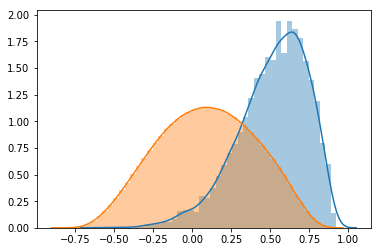

In [ ]:
print("Original")
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings_unique,  metric='correlation')
ranks_val_orig_all, ranks_val_orig_out, simsM_orig_all, simsNM_orig_all = get_val_scores(gex_chem_baseline_dist)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 196.000    MRR: 0.073    H@10: 0.135    H@100: 0.384    H@500: 0.706
Val (In Train):         median_rank: 149.000    MRR: 0.086    H@10: 0.157    H@100: 0.434    H@500: 0.770
Val (Not in Train):     median_rank: 670.000    MRR: 0.013    H@10: 0.032    H@100: 0.157    H@500: 0.412
Val (No train, limited):median_rank: 93.000    MRR: 0.056    H@10: 0.136    H@100: 0.521    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.4580735706821756
Average correlation between unmatched GE and Chem embeds (CAA):  0.027034534407680434
Difference:  0.43103903627449514



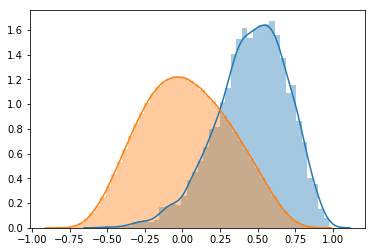

In [ ]:
ranks_val_cca_all, ranks_val_cca_out, simsM_cca_all, simsNM_cca_all = cca_cor()

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 644.000    MRR: 0.035    H@10: 0.063    H@100: 0.206    H@500: 0.444
Val (In Train):         median_rank: 523.000    MRR: 0.040    H@10: 0.072    H@100: 0.237    H@500: 0.490
Val (Not in Train):     median_rank: 1282.000    MRR: 0.010    H@10: 0.022    H@100: 0.062    H@500: 0.236
Val (No train, limited):median_rank: 131.000    MRR: 0.041    H@10: 0.068    H@100: 0.400    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.1710796949125439
Average correlation between unmatched GE and Chem embeds (CAA):  0.004361928480679614
Difference:  0.16671776643186428



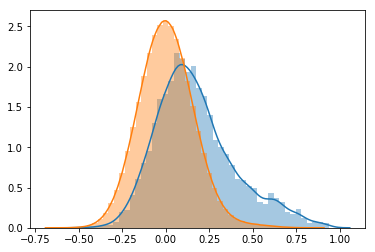

In [ ]:
ranks_val_geEmbed_fps_all, ranks_val_geEmbed_fps_out, simsM_geEmbed_fps_all, simsNM_geEmbed_fps_all = cca_cor(ncomp = 50,
                                                                                                              embeds_chem_train=fingerprints_train,
                                                                                                              embeds_chem_val=fingerprints,
                                                                                                              embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 403.000    MRR: 0.049    H@10: 0.091    H@100: 0.267    H@500: 0.538
Val (In Train):         median_rank: 316.000    MRR: 0.058    H@10: 0.107    H@100: 0.305    H@500: 0.585
Val (Not in Train):     median_rank: 896.000    MRR: 0.008    H@10: 0.019    H@100: 0.095    H@500: 0.321
Val (No train, limited):median_rank: 101.000    MRR: 0.048    H@10: 0.079    H@100: 0.499    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.2310195294066332
Average correlation between unmatched GE and Chem embeds (CAA):  0.009272042965942489
Difference:  0.2217474864406907



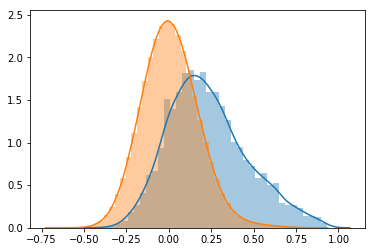

In [ ]:
ranks_val_geEmbed_chemprop_all, ranks_val_geEmbed_chemprop_out, simsM_geEmbed_chemprop_all, simsNM_geEmbed_chemprop_all = cca_cor(ncomp = 50,
                                                                                                                                  embeds_chem_train=chem_embeddings_chemprop_train,
                                                                                                                                  embeds_chem_val=chem_embeddings_chemprop,
                                                                                                                                  embeds_chem_uniq_val=chem_embeddings_unique_chemprop
                                                                                                                         )

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 1102.000    MRR: 0.037    H@10: 0.063    H@100: 0.154    H@500: 0.319
Val (In Train):         median_rank: 1005.000    MRR: 0.043    H@10: 0.074    H@100: 0.174    H@500: 0.341
Val (Not in Train):     median_rank: 1395.500    MRR: 0.007    H@10: 0.011    H@100: 0.062    H@500: 0.216
Val (No train, limited):median_rank: 134.000    MRR: 0.039    H@10: 0.065    H@100: 0.389    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.09531477236213479
Average correlation between unmatched GE and Chem embeds (CAA):  0.0006167351511649946
Difference:  0.0946980372109698



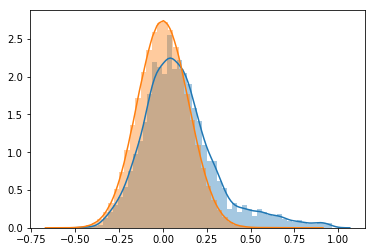

In [ ]:
ranks_val_rawGE_fps_all, ranks_val_rawGE_fps_out, simsM_rawGE_fps_all, simsNM_rawGE_fps_all = cca_cor(ncomp = 50,
                                                           embeds_ge_train=gex_raw_train[:,-978:],
                                                           embeds_chem_train=fingerprints_train,
                                                           embeds_ge_val=gex_raw[:,-978:],
                                                           embeds_chem_val=fingerprints,
                                                           embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 874.000    MRR: 0.045    H@10: 0.078    H@100: 0.192    H@500: 0.380
Val (In Train):         median_rank: 823.000    MRR: 0.053    H@10: 0.089    H@100: 0.210    H@500: 0.397
Val (Not in Train):     median_rank: 1095.000    MRR: 0.011    H@10: 0.024    H@100: 0.108    H@500: 0.299
Val (No train, limited):median_rank: 116.500    MRR: 0.055    H@10: 0.096    H@100: 0.447    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.12990687404735704
Average correlation between unmatched GE and Chem embeds (CAA):  0.0025680798451618967
Difference:  0.12733879420219515



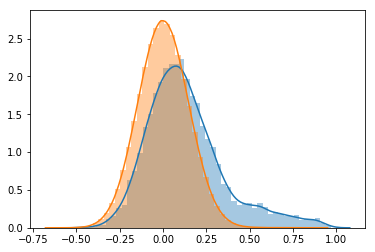

In [ ]:
ranks_val_rawGE_chemprop_all, ranks_val_rawGE_chemprop_out, simsM_rawGE_chemprop_all, simsNM_rawGE_chemprop_all = cca_cor(ncomp = 50,
                                                                                                                          embeds_ge_train=gex_raw_train[:,-978:],
                                                                                                                          embeds_ge_val=gex_raw[:,-978:],
                                                                                                                          embeds_chem_train=chem_embeddings_chemprop_train,
                                                                                                                          embeds_chem_val=chem_embeddings_chemprop,
                                                                                                                          embeds_chem_uniq_val=chem_embeddings_unique_chemprop
                                                                                                                         )

In [ ]:
ranks_val_rawGE_chemEmbed_all, ranks_val_rawGE_chemEmbed_out, simsM_rawGE_chemEmbed_all, simsNM_rawGE_chemEmbed_all = cca_cor(ncomp = 50,
                                                                       embeds_ge_train=gex_raw_train[:,-978:],
                                                                       embeds_ge_val=gex_raw[:,-978:])

CCA w/ 50 components


## Plots

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_all, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_all, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_all, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_all, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_all, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_all, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_all, cumulative=True, label = "margin_margin_noCCA")
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sns.kdeplot(ranks_val_rawGE_fps_out, cumulative=True, label = 'rawGE_fps')
sns.kdeplot(ranks_val_rawGE_chemprop_out, cumulative=True, label = 'rawGE_PT')
sns.kdeplot(ranks_val_rawGE_chemEmbed_out, cumulative=True, label = 'rawGE_margin')
sns.kdeplot(ranks_val_geEmbed_fps_out, cumulative=True, label = "margin_fps")
sns.kdeplot(ranks_val_geEmbed_chemprop_out, cumulative=True, label = "margin_PT")
sns.kdeplot(ranks_val_cca_out, cumulative=True, label = "margin_margin_CCA")
sns.kdeplot(ranks_val_orig_out, cumulative=True, label = "margin_margin_noCCA")
plt.show()

## Save results